In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import geometry
import shapely.speedups
from geopy.distance import geodesic
from tqdm import tqdm
from sklearn.cluster import KMeans
from quetzal.model import stepmodel

SQLalchemy is not installed. No support for SQL output.


# Preparation of input data
## Generates a DataFrame of PT stops with mean weighted distances to population cells
## Needs all PT nodes

In [2]:
input_path = '../input_static/spatial_'
output_path = '../output/'
model_path = '../model/'

In [12]:
sm = stepmodel.read_json(model_path + 'de_pt_network')

zones: 100%|██████████| 27/27 [00:00<00:00, 107.02it/s]          


In [13]:
# Map nodes to zones
if 'NUTS_ID' not in sm.nodes.columns:
    shapely.speedups.enable()
    sm.nodes['NUTS_ID'] = np.nan
    for _, zone in tqdm(sm.zones.iterrows(), total=sm.zones.shape[0]):
        sm.nodes.loc[sm.nodes['geometry'].within(zone['geometry']), 'NUTS_ID'] = zone['NUTS_ID']
    sm.to_json(model_path + 'de_pt_network',
          only_attributes=['zones', 'links', 'nodes',
                           'pt_routes', 'agencies',
                           'pt_route_types'], encoding='utf-8')

jsons: 100%|██████████| 4/4 [00:21<00:00,  5.34s/it]


In [10]:
bus = stepmodel.read_json(model_path + 'de_pt_network_bus')

zones: 100%|██████████| 6/6 [03:58<00:00, 39.77s/it]


In [11]:
# Map bus nodes to zones
if 'NUTS_ID' not in bus.nodes.columns:
    shapely.speedups.enable()
    bus.nodes['NUTS_ID'] = np.nan
    for _, zone in tqdm(bus.zones.iterrows(), total=bus.zones.shape[0]):
        bus.nodes.loc[bus.nodes['geometry'].within(zone['geometry']), 'NUTS_ID'] = zone['NUTS_ID']
    bus.to_json(model_path + 'de_pt_network_bus',
          only_attributes=['zones', 'links', 'nodes',
                           'pt_route_types', 'agencies',
                           'pt_routes'], encoding='utf-8')

jsons: 100%|██████████| 6/6 [09:20<00:00, 93.40s/it]     


In [14]:
# Merge
sm.nodes = sm.nodes.append(bus.nodes)

## Use census data
The important question for mode choice problems: How long/inconvenient is it from home to the next PT stop? </br>
Approach: Build population densities from census data and calculate the mean weighted distance to the next PT stop.

In [15]:
# Load census data: Zensus 2011 - Einwohnerzahl je Hektar
# Copyright: © Statistisches Bundesamt, Wiesbaden 2015
# (im Auftrag der Herausgebergemeinschaft)
# Vervielfältigung und Verbreitung, auch auszugsweise, mit Quellenangabe gestattet
if os.path.isfile(input_path + 'Zensus_2011.geojson'):
    pop = gpd.read_file(input_path + 'Zensus_2011.geojson', driver='GeoJSON')
else:
    pop = pd.read_csv(input_path + 'Zensus_2011.csv', sep=';')
    # Restrict to entries that hold information
    pop = pop.loc[pop['Einwohner']!=-1]
    pop = gpd.GeoDataFrame(pop[['Einwohner']],
                          geometry=gpd.points_from_xy(pop['x_mp_100m'], pop['y_mp_100m']))
    pop.crs = 3035
    pop.to_crs(sm.epsg, inplace=True)

In [16]:
print(pop.shape)
pop.head(2)

(3177723, 2)


,Einwohner,geometry
3669,8,POINT (10.21212 47.31574)
3710,7,POINT (10.26631 47.31562)


In [17]:
pop_r = pop

In [7]:
# Restrict to a geometric hull
#zones = gpd.read_file("../input/network/zones/NUTS_RG_01M_2016_4326.geojson")
#zones = zones[zones["CNTR_CODE"] == "DE"]
#zones = zones[zones["id"].str.startswith("DE73")] # only Kassel and surrounding
#hull = zones["geometry"].values[0].buffer(1e-3) # index 0 for Germany; 12 for Berlin
# Restrict to the geometric hull if the latter is not Germany
#pop_r = pop.loc[pop['geometry'].apply(lambda p: p.within(hull))]
#print(pop_r.shape)

In [18]:
# Map to zones
if 'NUTS_ID' not in pop_r.columns:
    shapely.speedups.enable()
    pop_r['NUTS_ID'] = np.nan
    for _, zone in tqdm(sm.zones.iterrows(), total=sm.zones.shape[0]):
        pop_r.loc[pop_r['geometry'].within(zone['geometry']), 'NUTS_ID'] = zone['NUTS_ID']
    pop_r.to_file(input_path + 'Zensus_2011.geojson', driver='GeoJSON')

100%|██████████| 401/401 [2:15:20<00:00, 20.25s/it]  


In [19]:
pop_r.loc[pop_r['NUTS_ID'].isna()]

,Einwohner,geometry,NUTS_ID
110339,5,POINT (9.91838 47.53103),NaN
115713,13,POINT (9.73521 47.53524),NaN
116840,13,POINT (9.73654 47.53615),NaN
154989,19,POINT (9.74703 47.56137),NaN
179635,5,POINT (8.08700 47.55841),NaN
...,...,...,...
35780872,3,POINT (8.69160 54.90699),NaN
35780956,3,POINT (8.69001 54.90787),NaN
35781241,9,POINT (8.67119 54.91127),NaN
35781242,3,POINT (8.67275 54.91129),NaN


<AxesSubplot:>

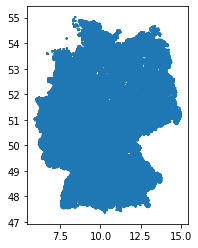

In [20]:
# Visualise
#zones_plot = sm.plot('zones', alpha=0.1, figsize=[16, 9], color='green')
pop_r.plot(markersize=list(pop_r['Einwohner']/58), alpha=0.2)#, ax=zones_plot)

### Apply K-Means to find weighted distances of PT stops

In [21]:
sm.nodes.shape

(423899, 5)

In [22]:
# Settings:
dist_col = 'weighted_dist'
mean_dist_col = 'mean_weighted_dist'
cent_col = 'cluster_center'
pop_col = 'population'
max_iter_per_group = 10

In [23]:
def weighted_dist(zone):
    nuts_id = zone['NUTS_ID'].unique()[0]
    # Get the population points
    pop_p = pop_r.loc[pop_r['NUTS_ID']==nuts_id]
    # Count the number of PT stops in the zone and make it the number of clusters
    n_clusters = len(zone.index)
    if n_clusters > 0:
        # Prepare sample
        X = np.array([[p.x, p.y] for p in list(pop_p['geometry'])])
        # Prepare initial starting points
        nodes_coords = np.array([[p.x, p.y] for p in list(zone['geometry'])])
        # Apply weighted K-Means
        kmeans = KMeans(n_clusters=n_clusters,
                        random_state=0,
                        init=nodes_coords,
                        max_iter=max_iter_per_group)
        kmeans.fit(X, sample_weight=np.array(list(pop_p['Einwohner'])))
        # Create results DataFrame
        zone[cent_col] = [geometry.Point(c[0], c[1]) for c in kmeans.cluster_centers_]
        # Add population to calculate the mean weighted distance for each zone later
        #pop_p['label'] = list(kmeans.labels_)
        #zone[pop_col] = list(pop_p.groupby('label').agg({'Einwohner': 'sum'})['Einwohner'])
        #zone[pop_col] = sm.zones.loc[nuts_id, 'population']
        # Calculate distance between centroid and PT node
        zone[dist_col] = [geodesic(kmeans.cluster_centers_[i], nodes_coords[i]).km * 1000
                          for i in range(n_clusters)]
        # Add mean weighted distance
        zone[mean_dist_col] = zone[dist_col].mean()
        return zone
    else:
        return

In [24]:
# Generate clusters for every route type
tqdm.pandas()
clusters = sm.nodes.groupby(['route_type', 'NUTS_ID']).progress_apply(weighted_dist)

100%|██████████| 1232/1232 [35:24<00:00,  1.72s/it] 


In [54]:
clusters.sample(4)

,route_type,stop_name,geometry,NUTS_ID,cluster_center,weighted_dist,mean_weighted_dist
bus_node_221326,bus,"Laggenbeck, Maug/Goldhügel",POINT (7.78982 52.28185),DEA37,POINT (7.790976683345642 52.27827429601009),414.030564,6540.454340
bus_node_x323301,bus,Silberhütte Forsthaus Fürst Viktor,POINT (11.09340 51.61980),DEE09,POINT (11.08931716925409 51.61431312284276),750.283909,4416.224758
bus_node_141038,bus,Hofgeismar Hofgeismar Eschstruthplatz,POINT (9.38708 51.49184),DE734,POINT (9.386974045663941 51.49164765499887),24.213315,2978.595075
bus_node_198154,bus,"Bü-Hunnebrock, Heide",POINT (8.58709 52.17711),DEA43,POINT (8.585679625948822 52.17912697739152),271.394106,1731.581980


route_type
air                    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
bus                    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
coach                  [[AxesSubplot(0.125,0.125;0.775x0.755)]]
rail_long_distance     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
rail_short_distance    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

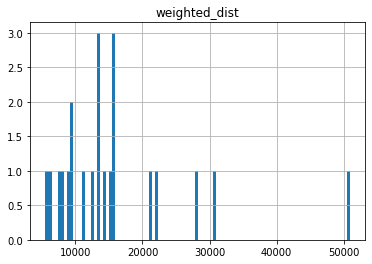

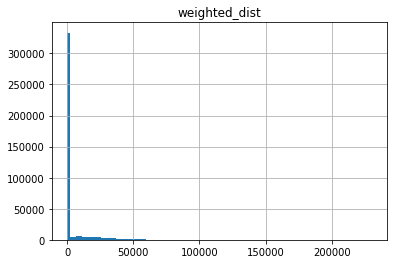

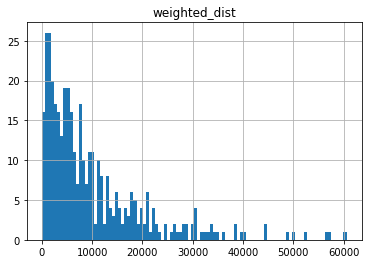

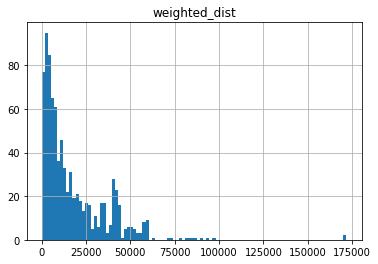

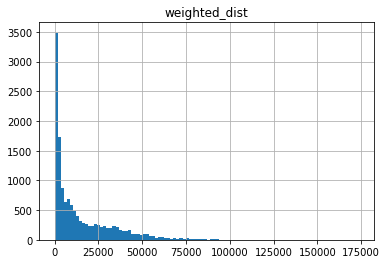

In [26]:
clusters.groupby('route_type').hist(column=dist_col, bins=100)

In [55]:
# Save the population centroids
clusters.to_csv('../input/spatial_census_refined.csv')